# Import Data

In [2]:
import pandas as pd

# Load the training data
train_df = pd.read_csv('../data/train.csv')
train_df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [3]:
calories = train_df.drop("Calories", axis=1)
calories_labels = train_df["Calories"].copy()

Data Selection and Prepration

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Identify numerical and categorical columns
numerical_cols = ['Duration', 'Heart_Rate', 'Body_Temp']
categorical_cols = ['Sex']

# Define the transformers
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [5]:
# Apply the preprocessor pipeline to the calories dataframe
X_prepared = preprocessor.fit_transform(calories)

# X_prepared is now ready for modeling!
print(X_prepared.shape)

(750000, 5)


In [6]:
# Get feature names after transformation
feature_names = (
    numerical_cols +
    list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols))
)

import pandas as pd
X_prepared_df = pd.DataFrame(X_prepared, columns=feature_names)
print(X_prepared_df.head())

   Duration  Heart_Rate  Body_Temp  Sex_female  Sex_male
0  1.266324    0.583714   1.235772         0.0       1.0
1 -0.888309   -1.109436  -0.431163         1.0       0.0
2 -1.008011   -1.215258  -0.302938         1.0       0.0
3  1.146622    1.007002   0.851095         0.0       1.0
4  1.146622    0.689536   0.722869         1.0       0.0


# Models and Evaluation

Linear Regression 10-Fold CV RMSE: 13.91
Linear Regression 10-Fold CV Std of Errors: 13.91


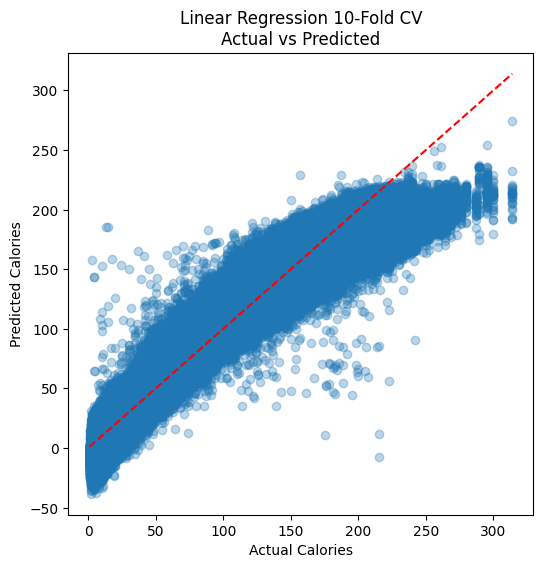

Decision Tree 10-Fold CV RMSE: 10.85
Decision Tree 10-Fold CV Std of Errors: 10.85


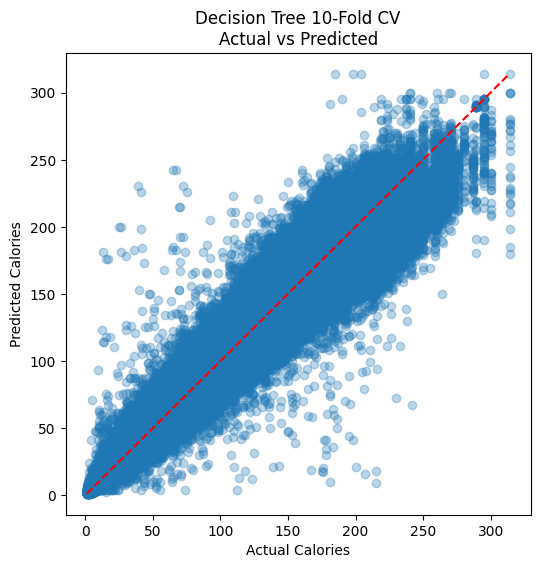

Random Forest 10-Fold CV RMSE: 10.75
Random Forest 10-Fold CV Std of Errors: 10.75


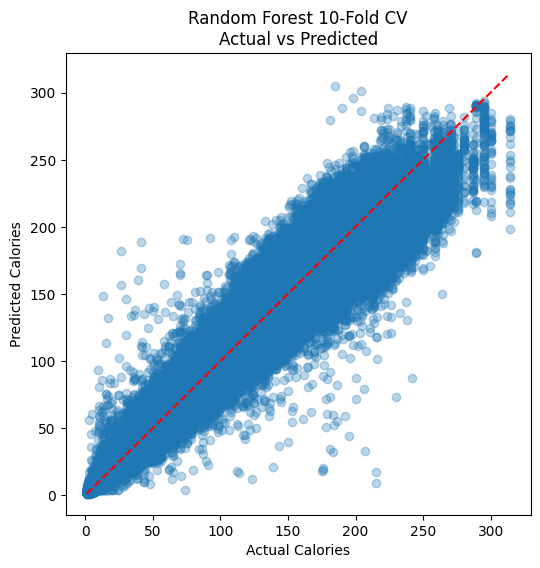

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1)
}

for name, model in models.items():
    cv_pred = cross_val_predict(model, X_prepared, calories_labels, cv=10)
    rmse = np.sqrt(mean_squared_error(calories_labels, cv_pred))
    std_error = np.std(calories_labels - cv_pred)
    print(f"{name} 10-Fold CV RMSE: {rmse:.2f}")
    print(f"{name} 10-Fold CV Std of Errors: {std_error:.2f}")
    plt.figure(figsize=(6, 6))
    plt.scatter(calories_labels, cv_pred, alpha=0.3)
    plt.plot([calories_labels.min(), calories_labels.max()], [calories_labels.min(), calories_labels.max()], 'r--')
    plt.xlabel('Actual Calories')
    plt.ylabel('Predicted Calories')
    plt.title(f'{name} 10-Fold CV\nActual vs Predicted')
    plt.show()

Random Forest is likely the best model for this problem, as it fits the data well and generalizes better than a single Decision Tree.

Linear Regression is too simple for the complexity of the data.

Decision Tree overfits the training data and may not perform as well on new data.


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Initialize the model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Fit to your data
grid_search.fit(X_prepared, calories_labels)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best RMSE (negative):", grid_search.best_score_)
print("Best RMSE (positive):", -grid_search.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_

/Users/ayushupadhyay/Documents/GitHub/calorie_expenditure_prediction/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
461 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ayushupadhyay/Documents/GitHub/calorie_expenditure_prediction/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ayushupadhyay/Documents/GitHub/calorie_expenditure_prediction/venv/lib/python3.10/site-packages/sklearn/base.py", line 1356, in wrapper
    estimator._validate_params()
  

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best RMSE (negative): -10.656602956275822
Best RMSE (positive): 10.656602956275822
